# Using VAEs as a Data Augmentation Technic
## Observations
 - Slightly improves f1-scores in few-shot scenarios
 - only yields improvments when generated samples do NOT dominate the original samples, i.e. do not generate more examples than the original dataset holds!
 - for non-few-shot scenarios the augmentation leads to faster and more stable convergence but not to an overall better performance of the model
 - often the f1-scores tend to rise faster when using additional generated data espiacially in early stages of training (first ~100 steps)
 - it seems like one cannot train the VAEs enough. The longer the better, which is weird because usually this means that the generated samples are very close to the original ones used for training

In [1]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange
from sklearn.metrics import f1_score
# tensorflow is only used to
# download the mnist dataset
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set seed
seed = 1337
# set cudnn backend to be deterministic
torch.backends.cudnn.deterministic = True
# utility function for seeding
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Hyperparameters

In [3]:
# data hyperparameters
n_originals_per_class =     10
n_generated_per_class =     10
# vae hyperparamters
vae_z_dim =                 2
vae_training_steps =        5000
vae_beta =                  0.5
vae_batch_size =            2
# gc hyperparameters
gc_training_steps =         1200
gc_batch_size =             16
# cnn model hyperparameters
cnn_training_steps =        500
cnn_batch_size =            32
cnn_eval_interval =         20
# cuda
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda:0


## Data Preparation


In [4]:
# load mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# data preparation
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)
# separate dataset into the different classes
train_per_label = [x_train[y_train == i] for i in range(10)]
test_per_label = [x_test[y_test == i] for i in range(10)]
# seed
seed_everything(seed)
# randomly choose a number of samples for training set
train_per_label = [X[np.random.permutation(X.shape[0])[:n_originals_per_class], ...] for X in train_per_label]

# Variational Auto-Encoder

In [5]:
class Encoder(nn.Sequential):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        nn.Sequential.__init__(self,
            # Convolution 1 - input shape (1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            # Convolution 1 - input shape (32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            # dense - input shape (64, 7, 7) 
            # output dimension is 2 * z-dim (concat mean and variance vectors)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 2 * z_dim)
        )
    def forward(self, x):
        mean_variance = nn.Sequential.forward(self, x)
        mean, log_variance = mean_variance[..., :self.z_dim], mean_variance[..., self.z_dim:]
        # actually computes the log of the variance
        return mean, log_variance
class Decoder(nn.Module):
    def __init__(self, z_dim):
        nn.Module.__init__(self)
        self.linear = nn.Linear(z_dim, 64 * 7 * 7)
        self.conv = nn.Sequential(
            # transpose convolution 1 - input shape (64, 7, 7)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # transpose convolution 2 - input shape (32, 14, 14)
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # pixel-wise linear - input shape (16, 28, 28)
            nn.Conv2d(16, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # output shape (1, 28, 28)
        )
    def forward(self, z):
        x = self.linear(z).relu()
        x = x.reshape(-1, 64, 7, 7)
        return self.conv(x)
class VAE(nn.Module):
    def __init__(self, z_dim):
        nn.Module.__init__(self)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    def forward(self, x):
        # encode
        mean, variance_log = self.encoder(x)
        # sample from encoding
        if self.training:
            eps = torch.empty_like(variance_log).normal_()
            z = eps * (variance_log / 2).exp() + mean
        else:
            # in evaluation use the mean
            z = mean
        # decode from sample
        x_ = self.decoder(z)
        return x_, mean, variance_log

In [6]:
seed_everything(seed)
# create one VAE model for each class
vae_per_label = [VAE(z_dim=vae_z_dim) for _ in range(len(train_per_label))]

### Training the VAE Models

In [7]:
vae_gc_state_dicts = []
# train each vae on the specific data
for k, (X, vae) in enumerate(zip(train_per_label, vae_per_label)):
    r_losses, kl_losses = [], []
    X = torch.FloatTensor(X)
    # move vae to device and set it to train mode
    # also create an optimizer
    vae.to(device).train()
    optim = torch.optim.Adam(vae.parameters(), weight_decay=0.01)
    t = trange(vae_training_steps, disable=True)
    for i in t:
        # get batch to train from
        x_idx = np.random.randint(0, n_originals_per_class, vae_batch_size)
        x = X[x_idx].to(device)
        # predict and compute loss
        x_, m, v_log = vae(x)
        r_l = F.binary_cross_entropy(x_, x) * 28 * 28
        kl_l = vae_beta * (v_log.exp() + m**2 - 1 - v_log).sum(-1).mean()
        # update parameters
        optim.zero_grad()
        (r_l + kl_l).backward()
        optim.step()
        # update losses
        r_losses.append(r_l.item())
        kl_losses.append(kl_l.item())
        # update progress bar
        t.set_postfix({'r-loss': r_losses[-1], 'kl-loss': kl_losses[-1]})
        
        if i == gc:
            vae_gc_state_dicts.append({k: t.clone() for k, t in vae.state_dict().items()})
    # close tqdm bar
    t.close()
    # move model back to cpu and 
    # set into eval mode after training
    # is finished
    vae.to('cpu').eval()
    # feedback
    print("k=%i\t r-loss: %.03f\t kl-loss: %.03f" % (k, r_losses[-1], kl_losses[-1]))

k=0	 r-loss: 57.913	 kl-loss: 4.597
k=1	 r-loss: 29.213	 kl-loss: 3.958
k=2	 r-loss: 44.547	 kl-loss: 4.931
k=3	 r-loss: 51.111	 kl-loss: 5.565
k=4	 r-loss: 47.609	 kl-loss: 4.318
k=5	 r-loss: 39.352	 kl-loss: 5.144
k=6	 r-loss: 52.789	 kl-loss: 5.054
k=7	 r-loss: 47.230	 kl-loss: 4.407
k=8	 r-loss: 76.768	 kl-loss: 8.873
k=9	 r-loss: 49.124	 kl-loss: 5.500


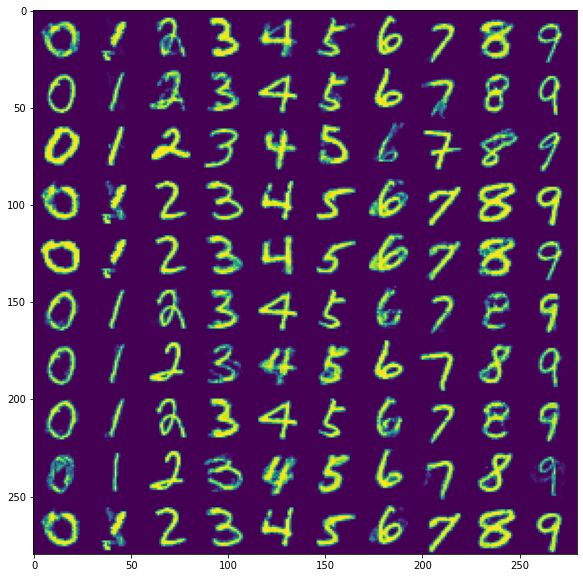

In [8]:
# generate new examples from normal distribution
z_rand = torch.empty(10, vae_z_dim).normal_(0, 1)
with torch.no_grad():
    x_gen = torch.cat([
        vae.decoder.forward(z_rand).reshape(-1, 28)
        for vae in vae_per_label
    ], dim=1)
# plot
figsize(10, 10)
figure()
imshow(x_gen.numpy())
show()

# Generative Classifier
We train a classifier to decide which images are generated by an vae and which ones aren't. By only training the model for a few steps we hope to ensure that the vae still generates images that are not discarded by the generative classifier.

This can defently and easily be done better!

The Problem with this idea is that the classifier will prefer those samples that are strongly related to the provided dataset, thus it will reduce variance in the generated examples.

In [9]:
class GenerativeClassifier(nn.Module):
    def __init__(self):
        super(GenerativeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4 * 4 * 4, 8)
        self.fc2 = nn.Linear(8, 1)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 4 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [10]:
import numpy as np
import torchvision.utils as vutils

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
def load_state_dict(state_dict):
    vae = VAE(z_dim=vae_z_dim)
    vae.load_state_dict(state_dict)
    vae.eval()
    return vae

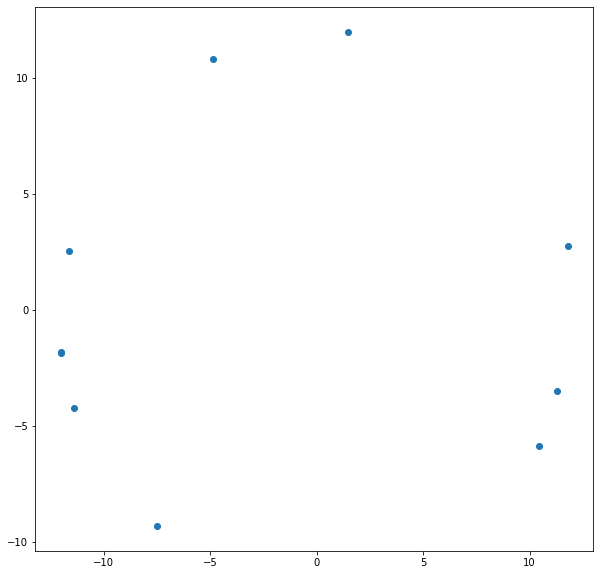

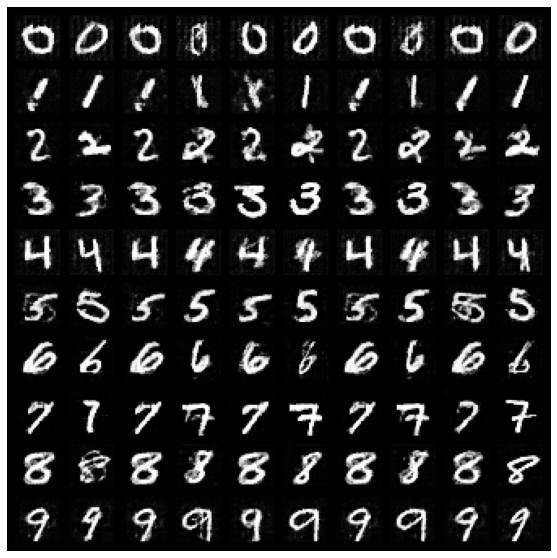

In [11]:
seed_everything(seed)
# build dataset of fake and real samples
real_x = torch.FloatTensor(np.concatenate(train_per_label, axis=0))
with torch.no_grad():
    phi = np.random.uniform(-2*np.pi, 2*np.pi, size=(n_originals_per_class,))
    rho = np.random.normal(12, 0.1, size=(n_originals_per_class,))
    z_rand = torch.FloatTensor(pol2cart(rho, phi)).T
    fake_x = torch.cat([
        load_state_dict(sd).decoder.forward(z_rand)
        for sd in vae_gc_state_dicts
    ], dim=0)
# create labels
real_y = torch.ones(real_x.size(0))
fake_y = torch.zeros(fake_x.size(0))
# pack into dataset
gc_dataset = torch.utils.data.TensorDataset(
    torch.cat((real_x, fake_x), dim=0),
    torch.cat((real_y, fake_y), dim=0)
)

figure()
scatter(*z_rand.T)
show()

figure()
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(fake_x, padding=5, normalize=True, nrow=10),
        (1, 2, 0),
    ),
)
plt.show()

In [12]:
seed_everything(seed)
# train generative classifier
gc = GenerativeClassifier()
device = 'cpu'
gc.to(device).train()
optim = torch.optim.Adam(gc.parameters())

t = trange(gc_training_steps)
for i in t:
    # get batch to train on
    batch_idx = np.random.randint(0, len(gc_dataset), gc_batch_size)
    x, y_hat = gc_dataset[batch_idx]
    # apply model and compute loss
    y = gc.forward(x.to(device)).flatten()
    loss = F.binary_cross_entropy(y, y_hat.to(device)) + 0.05 * (1 - y).mean()
    # update model parameters
    optim.zero_grad()
    loss.backward()
    optim.step()

# move classifier back to cpu
# and set it into evaluation mode
gc = gc.to('cpu').eval()

  0%|          | 0/1200 [00:00<?, ?it/s]

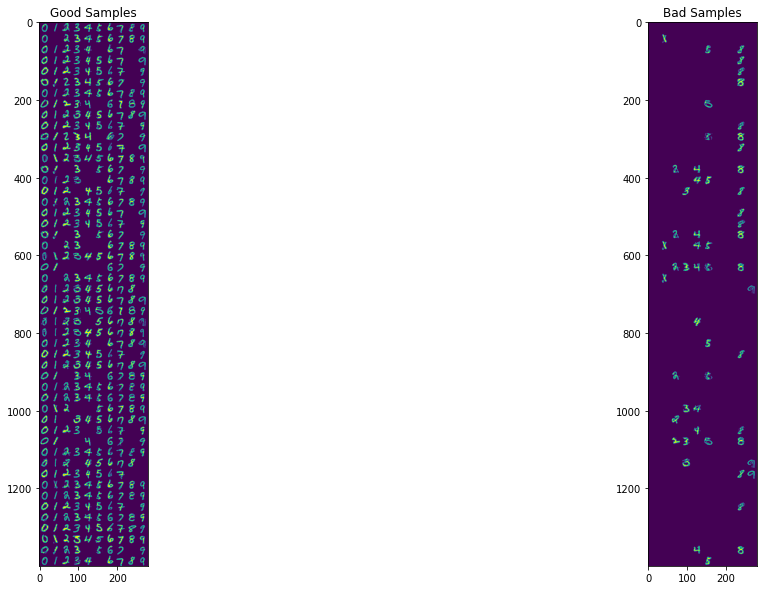

In [13]:
seed_everything(seed)
# generate some samples
with torch.no_grad():
    z_rand = torch.empty(50, vae_z_dim).normal_(0, 1)
    x_gen = torch.cat([
        vae.decoder.forward(z_rand)
        for vae in vae_per_label
    ], dim=0)
    # apply generative classifier
    mask = gc.forward(x_gen) > 0.5
# convert to numpy
x_gen = x_gen.numpy()
mask = mask.numpy()
# apply mask
x_good, x_bad = x_gen.copy(), x_gen.copy()
x_good[~mask], x_bad[mask] = 0, 0

# visualize the choice of
# the generative classifier
_, (ax_good, ax_bad) = subplots(1, 2, figsize=(20, 10))
ax_good.set_title("Good Samples")
ax_bad.set_title("Bad Samples")
ax_good.imshow(x_good.reshape(10, 50, 28, 28).transpose(1, 2, 0, 3).reshape(28 * 50, 280))
ax_bad.imshow(x_bad.reshape(10, 50, 28, 28).transpose(1, 2, 0, 3).reshape(28 * 50, 280))
show()

# CNN Model as Baseline

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4 * 4 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

### Training script for the CNN Model

In [15]:
# convert testing data to tensors
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
def train_cnn(dataset):
    seed_everything(seed)
    # create a cnn model
    model = CNN()
    # move model to device and set
    # it in train mode
    model.to(device).train()
    optim = torch.optim.Adam(model.parameters())
    # values we want to track
    train_losses, test_losses = [], []
    micro_f1_scores, macro_f1_scores = [], []
    # train loop
    t = trange(cnn_training_steps)
    for i in t:
        # get batch to train from
        x_idx = np.random.randint(0, len(dataset), cnn_batch_size)
        x, y_hat = dataset[x_idx]
        # apply model and compute loss
        y = model.forward(x.to(device))
        loss = F.nll_loss(y, y_hat.to(device))
        # update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
        # add loss value to list
        train_losses.append(loss.item())

        if (i % cnn_eval_interval == 0) or (i == vae_training_steps-1):
            # evaluate model
            model.eval()
            with torch.no_grad():
                # apply model to test data
                y = model.forward(x_test.to(device))
                loss = F.nll_loss(y, y_test.to(device))
                # add loss to list
                test_losses.append(loss.item())
                # get predictions and compute f1-scores
                y_pred = y.argmax(-1).cpu().numpy()
                micro_f1_scores.append(f1_score(y_test.numpy(), y_pred, average='micro'))
                macro_f1_scores.append(f1_score(y_test.numpy(), y_pred, average='macro'))
            # back to training the model
            model.train()
    # move model back to cpu and
    # set it to evaluation mode
    model.to('cpu').eval()
    # return model and tracked values
    return model, {
        'train-losses': train_losses, 
        'test-losses':  test_losses, 
        'micro-f1':     micro_f1_scores, 
        'macro-f1':     macro_f1_scores
    }

### Training models
Here we train three models, i.e.
 - one trained on only the originally provided (reduced!) dataset
 - one trained on the original together with some generated samples
 - and one where the generated examples are filtered by the generative classifier

  0%|          | 0/500 [00:00<?, ?it/s]

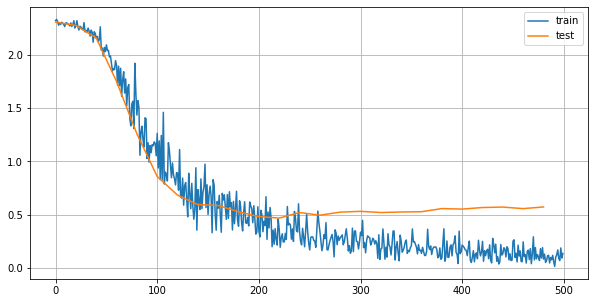

In [16]:
# build dataset of only the original samples
orig_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(train_per_label, axis=0)),
    torch.LongTensor(np.concatenate([
        (np.zeros(X.shape[0]) + i) for i, X in enumerate(train_per_label)
    ], axis=0))
)
# train model on dataset
model_orig, metrics_orig = train_cnn(orig_train_dataset)
# plot the losses
figsize(10, 5)
figure()
grid()
plot(metrics_orig['train-losses'], label='train')
ticks = [i * cnn_eval_interval for i in range(len(metrics_orig['test-losses']))]
plot(ticks, metrics_orig['test-losses'], label='test')
legend()
show()

  0%|          | 0/500 [00:00<?, ?it/s]

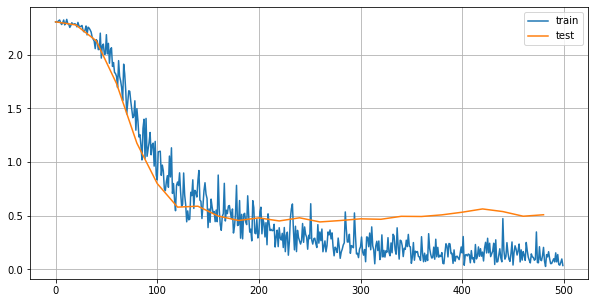

In [17]:
seed_everything(seed)
# build a dataset with both the original samples
# and also some generated ones using the vaes
with torch.no_grad():
    z_rand = torch.empty(n_generated_per_class, vae_z_dim).normal_(0, 1)
    generated_per_label = [
        vae.decoder.forward(z_rand).numpy()
        for vae in vae_per_label
    ]
# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
# full_train_x = generated_per_label
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen, metrics_gen = train_cnn(full_train_dataset)
# plot training and test losses
figsize(10, 5)
figure()
grid()
plot(metrics_gen['train-losses'], label='train')
ticks = [i * cnn_eval_interval for i in range(len(metrics_gen['test-losses']))]
plot(ticks, metrics_gen['test-losses'], label='test')
legend()
show()

  0%|          | 0/500 [00:00<?, ?it/s]

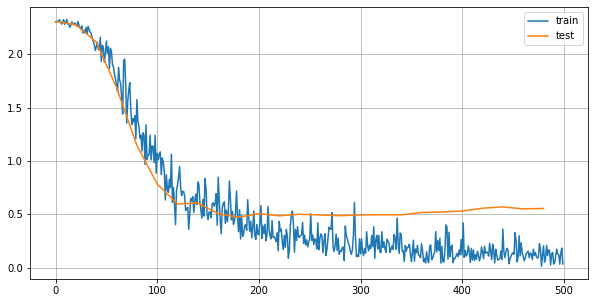

In [21]:
seed_everything(seed)
# build a dataset with both the original samples
# and also some generated ones using the vaes
with torch.no_grad():
    z_rand = torch.empty(n_generated_per_class * 30, vae_z_dim).normal_(0, 1)
    generated_per_label = [
        vae.decoder.forward(z_rand)
        for vae in vae_per_label
    ]
    # apply generative classifier
    masks_per_label = [
        gc.forward(x_gen).flatten() > 0.5
        for x_gen in generated_per_label
    ]
    generated_per_label = [
        x_gen[mask, ...].numpy()[:n_generated_per_class, ...]
        for x_gen, mask in zip(generated_per_label, masks_per_label)
    ]

# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
# full_train_x = generated_per_label
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen_gc, metrics_gen_gc = train_cnn(full_train_dataset)
# plot training and test losses
figsize(10, 5)
figure()
grid()
plot(metrics_gen_gc['train-losses'], label='train')
ticks = [i * cnn_eval_interval for i in range(len(metrics_gen_gc['test-losses']))]
plot(ticks, metrics_gen_gc['test-losses'], label='test')
legend()
show()

### Comparisson of F1-Scores

With Generated:		 0.872
With Generated+GC:	 0.8635
Without Generated:	 0.8643999999999998


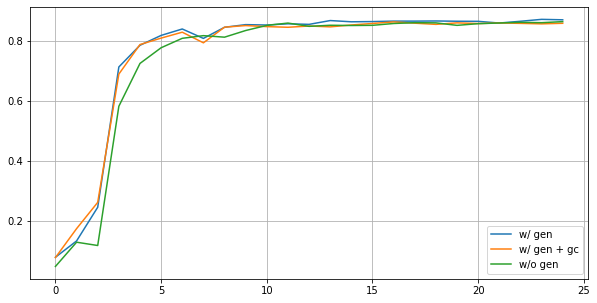

In [22]:
# compare f1 scores of both models
print("With Generated:\t\t", max(metrics_gen["micro-f1"]))
print("With Generated+GC:\t", max(metrics_gen_gc["micro-f1"]))
print("Without Generated:\t", max(metrics_orig['micro-f1']))
# also plot
figsize(10, 5)
figure()
grid()
plot(metrics_gen["micro-f1"], label="w/ gen")
plot(metrics_gen_gc["micro-f1"], label="w/ gen + gc")
plot(metrics_orig["micro-f1"], label="w/o gen")
legend()
show()

With Generated:		 0.8696558023496725
With Generated+GC:	 0.8617466248061831
Without Generated:	 0.86219496237574


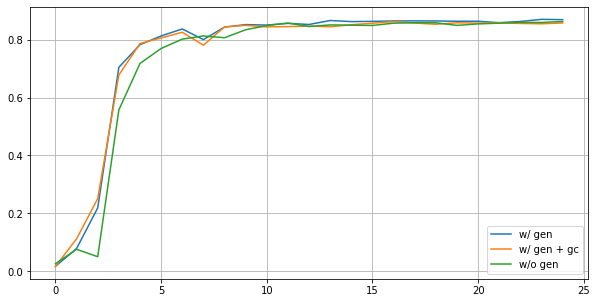

In [23]:
# compare f1 scores of both models
print("With Generated:\t\t", max(metrics_gen["macro-f1"]))
print("With Generated+GC:\t", max(metrics_gen_gc["macro-f1"]))
print("Without Generated:\t", max(metrics_orig['macro-f1']))
# also plot
figsize(10, 5)
figure()
grid()
plot(metrics_gen["macro-f1"], label="w/ gen")
plot(metrics_gen_gc["macro-f1"], label="w/ gen + gc")
plot(metrics_orig["macro-f1"], label="w/o gen")
legend()
show()